In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Imports successful!")

Imports successful!


In [64]:
player_df = pd.read_csv('player_data.csv')
season_df = pd.read_csv('Seasons_Stats.csv')

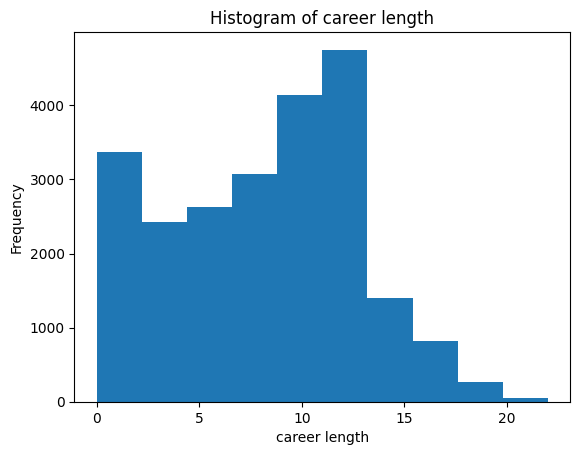

In [65]:
# Merging the data

len(player_df['name'].value_counts()[player_df['name'].value_counts() > 1])


# Joining the season data with player data to make player-season data
player_df["name"] = player_df["name"].str.strip()
season_df["Player"] = season_df["Player"].str.strip()

merged = season_df.merge(
    player_df,
    how="left",
    left_on="Player",
    right_on="name",
)

merged = merged[
    (merged["Year"] >= merged["year_start"]) &
    (merged["Year"] <= merged["year_end"])
]

merged.tail()

# Doing the merge this way truncated some values, but not a big deal because it is dummy data - but basically we can mention this as a risk

# Data already only contains players that retired
merged["year_end"].isnull().any()

# Create new columns years played so far, years left
merged['career_length'] = merged['year_end'] - merged['year_start']
merged['years_left'] = merged['year_end'] - merged['Year']
merged['years_played'] = merged['Year'] - merged['year_start']

import matplotlib.pyplot as plt

plt.hist(merged["career_length"])
plt.xlabel("career length")
plt.ylabel("Frequency")
plt.title("Histogram of career length")
plt.show()

In [66]:
# Adding in Missing Birthdays

# Manually found birthdays of missing players
# Bob Schafer
# Don Bielke
# Frank Reddout
# Ken McBride
# Mike O'Neill

# Bob Schafer
merged.loc[merged['Player'] == "Bob Schafer", 'birth_date'] = "March 29, 1933"
# Extract birth year as integer
merged['birth_year'] = merged['birth_date'].str[-4:].astype(float)
merged['Age'] = merged['Year'] - merged['birth_year']

# Don Bielke
merged.loc[merged['Player'] == "Don Bielke", 'birth_date'] = "May 10, 1932"
# Extract birth year as integer
merged['birth_year'] = merged['birth_date'].str[-4:].astype(float)
merged['Age'] = merged['Year'] - merged['birth_year']

# Frank Reddout
merged.loc[merged['Player'] == "Frank Reddout", 'birth_date'] = "March 4, 1931"
# Extract birth year as integer
merged['birth_year'] = merged['birth_date'].str[-4:].astype(float)
merged['Age'] = merged['Year'] - merged['birth_year']

# Ken McBride
merged.loc[merged['Player'] == "Ken McBride", 'birth_date'] = "March 23, 1929"
# Extract birth year as integer
merged['birth_year'] = merged['birth_date'].str[-4:].astype(float)
merged['Age'] = merged['Year'] - merged['birth_year']

# Mike O'Neill
merged.loc[merged['Player'] == "Mike O'Neill", 'birth_date'] = "August 11, 1928"
# Extract birth year as integer
merged['birth_year'] = merged['birth_date'].str[-4:].astype(float)
merged['Age'] = merged['Year'] - merged['birth_year']

In [67]:
# CLEANING UP DATA

# 1. Remove everything before 1980
merged = merged[merged['Year'] >= 1980].copy()

# 2. Sort properly
merged = merged.sort_values(['Player', 'birth_date', 'Year'])

# 3. Define the stat columns we want to average
stat_cols = [
    'G','GS','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
    'TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP','FG','FGA',
    'FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB','DRB',
    'TRB','AST','STL','BLK','TOV','PF','PTS'
]

# Only keep the columns that actually exist in merged
stat_cols = [col for col in stat_cols if col in merged.columns]

# 4. Average all stats for each unique Player + birth_date
averaged = (
    merged.groupby(['Player', 'birth_date'])[stat_cols].mean()
           .reset_index()
)

# 5. Merge back any non-stat metadata from the first occurrence

metadata_cols = ['college', 'career_length', 'year_start', 'year_end', 'height', 'weight']
metadata_cols = [col for col in metadata_cols if col in merged.columns]

metadata = (
    merged.groupby(['Player', 'birth_date'])[metadata_cols]
          .first()
          .reset_index()
)

# 6. Combine averaged stats + metadata
final_df = averaged.merge(metadata, on=['Player', 'birth_date'], how='left')

# 7. Fill numeric missing values with 0
numeric_cols = final_df.select_dtypes(include=['number']).columns
final_df[numeric_cols] = final_df[numeric_cols].fillna(0)

# 8. Display result
display(final_df.head())
print("Final shape:", final_df.shape)


,Player,birth_date,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,BLK,TOV,PF,PTS,college,career_length,year_start,year_end,height,weight
0,A.C. Green,"October 4, 1963",75.611111,50.277778,2169.111111,13.872222,0.543556,0.049,0.437111,10.388889,...,31.222222,83.777778,143.388889,718.222222,Oregon State University,15.0,1986.0,2001.0,6-9,220.0
1,A.J. Bramlett,"January 10, 1977",8.000000,0.000000,61.000000,-0.400000,0.190000,0.000,0.000000,21.700000,...,0.000000,3.000000,13.000000,8.000000,University of Arizona,0.0,2000.0,2000.0,6-10,227.0
2,A.J. English,"July 11, 1967",75.500000,9.000000,1554.000000,11.550000,0.480000,0.047,0.241000,4.900000,...,12.000000,101.500000,143.500000,751.000000,Virginia Union University,1.0,1991.0,1992.0,6-3,175.0
3,A.J. Guyton,"February 12, 1978",26.666667,4.666667,415.333333,4.366667,0.324000,0.371,0.068333,1.366667,...,4.000000,20.666667,19.333333,147.333333,Indiana University,2.0,2001.0,2003.0,6-1,180.0
4,A.J. Hammons,"August 27, 1992",22.000000,0.000000,163.000000,8.400000,0.472000,0.238,0.476000,5.400000,...,13.000000,10.000000,21.000000,48.000000,Purdue University,0.0,2017.0,2017.0,7-0,260.0


Final shape: (2784, 53)


In [68]:
## Add Rookie Age 

# Extract birth_year from birth_date
final_df['birth_year'] = pd.to_numeric(
    final_df['birth_date'].str[-4:], 
    errors='coerce'
)

# Calculate rookie age
final_df['rookie_age'] = final_df['year_start'] - final_df['birth_year']

# Replace any NaN rookie_age with 0
final_df['rookie_age'] = final_df['rookie_age'].fillna(0)

# Preview
final_df[['Player', 'birth_date', 'birth_year', 'rookie_age']].head()

,Player,birth_date,birth_year,rookie_age
0,A.C. Green,"October 4, 1963",1963,23.0
1,A.J. Bramlett,"January 10, 1977",1977,23.0
2,A.J. English,"July 11, 1967",1967,24.0
3,A.J. Guyton,"February 12, 1978",1978,23.0
4,A.J. Hammons,"August 27, 1992",1992,25.0


In [69]:
display(final_df)


,Player,birth_date,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,PF,PTS,college,career_length,year_start,year_end,height,weight,birth_year,rookie_age
0,A.C. Green,"October 4, 1963",75.611111,50.277778,2169.111111,13.872222,0.543556,0.049000,0.437111,10.388889,...,143.388889,718.222222,Oregon State University,15.0,1986.0,2001.0,6-9,220.0,1963,23.0
1,A.J. Bramlett,"January 10, 1977",8.000000,0.000000,61.000000,-0.400000,0.190000,0.000000,0.000000,21.700000,...,13.000000,8.000000,University of Arizona,0.0,2000.0,2000.0,6-10,227.0,1977,23.0
2,A.J. English,"July 11, 1967",75.500000,9.000000,1554.000000,11.550000,0.480000,0.047000,0.241000,4.900000,...,143.500000,751.000000,Virginia Union University,1.0,1991.0,1992.0,6-3,175.0,1967,24.0
3,A.J. Guyton,"February 12, 1978",26.666667,4.666667,415.333333,4.366667,0.324000,0.371000,0.068333,1.366667,...,19.333333,147.333333,Indiana University,2.0,2001.0,2003.0,6-1,180.0,1978,23.0
4,A.J. Hammons,"August 27, 1992",22.000000,0.000000,163.000000,8.400000,0.472000,0.238000,0.476000,5.400000,...,21.000000,48.000000,Purdue University,0.0,2017.0,2017.0,7-0,260.0,1992,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,Zeljko Rebraca,"April 9, 1972",34.142857,3.428571,507.571429,12.728571,0.558143,0.000000,0.369286,7.742857,...,80.571429,195.285714,None,4.0,2002.0,2006.0,7-0,257.0,1972,30.0
2780,Zendon Hamilton,"April 27, 1975",18.250000,1.875000,201.125000,13.400000,0.493375,0.000000,1.132000,10.275000,...,27.500000,76.375000,St. John's University,5.0,2001.0,2006.0,6-11,250.0,1975,26.0
2781,Zoran Dragic,"June 22, 1989",10.666667,0.666667,50.000000,8.433333,0.412667,0.500333,0.211000,10.133333,...,4.000000,18.666667,None,0.0,2015.0,2015.0,6-5,200.0,1989,26.0
2782,Zoran Planinic,"September 12, 1982",49.333333,3.333333,528.000000,9.800000,0.492000,0.261333,0.401667,3.533333,...,79.000000,187.000000,None,2.0,2004.0,2006.0,6-7,195.0,1982,22.0


In [70]:
## Feeder School Correlation

# Handle missing colleges (treat all missing as "unknown")
final_df['college'] = final_df['college'].fillna('Unknown').astype(str)

print("Number of 'Unknown' colleges:", (final_df['college'] == 'Unknown').sum())

# Compute average career length per college (feeder-school strength score)
college_scores = (
    rookie_df
    .groupby('college', as_index=False)['career_length']
    .mean()
    .rename(columns={'career_length': 'college_longevity_score'})
)

# See top feeder schools
college_scores.sort_values('college_longevity_score', ascending=False).head(10)

# Merge scores back into rookie_df
final_df = pd.merge(final_df, college_scores, on='college', how='left')


#rookie_df[['name', 'college', 'college_longevity_score']].head()

Number of 'Unknown' colleges: 257


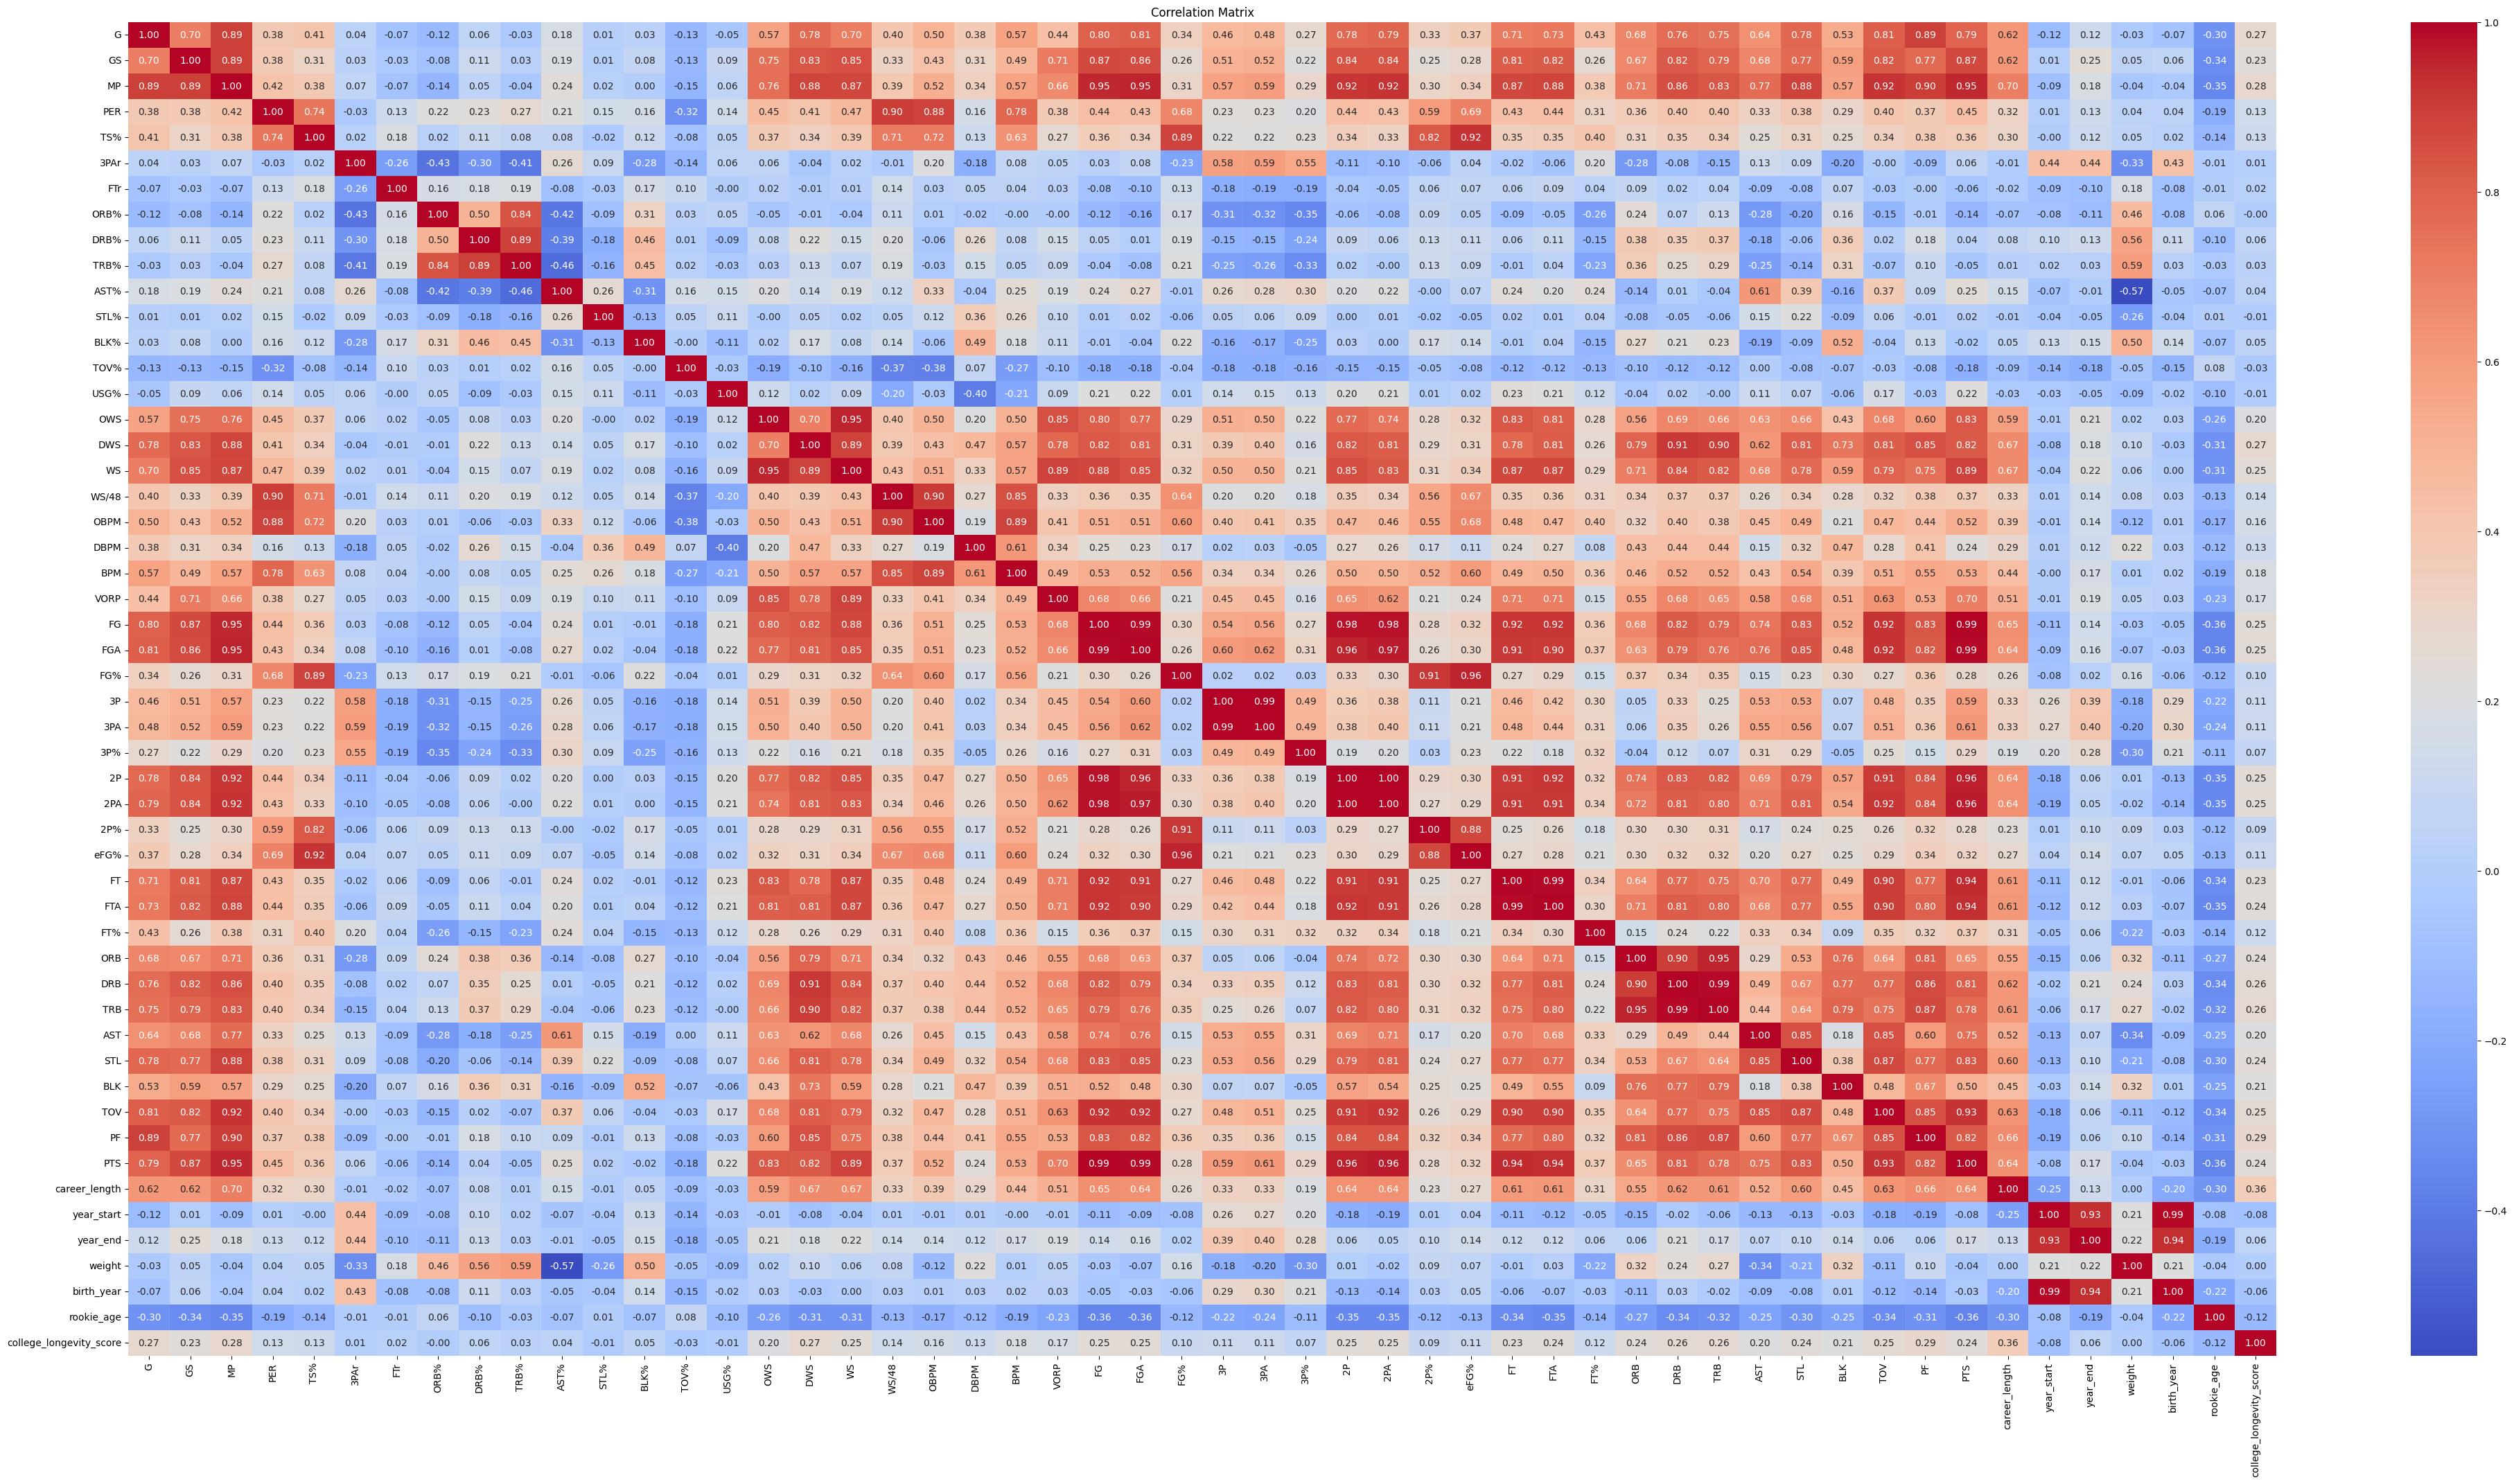

In [71]:
# Correlation Matrix
# CORRELATION MATRIX (SEE NUMERICAL CORRELATION)
correlation_matrix = final_df.corr(numeric_only=True)
# Create a masked matrix showing only correlations above 0.4 (absolute value)
# filtered_matrix = correlation_matrix[np.abs(correlation_matrix) >= 0.4]

# Optionally, replace NaNs with a visual indicator (e.g., empty string or a specific color in a heatmap)
# filtered_matrix = filtered_matrix.fillna('')

# Create a heatmap
plt.figure(figsize=(50, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [9]:
## FINAL FEATURED MODEL

# Feature model columns
feature_cols = [
    'WS',
    'MP',
    'college_longevity_score',
    'FG'
]

target_col = 'career_length'

# Build modelling dataframe WITHOUT dropping anything
model_df = rookie_df[feature_cols + [target_col]]

print("Shape of model_df:", model_df.shape)

# Count missing values per column
print("\nMissing values per column:")
print(model_df.isna().sum())

# Preview first few rows
model_df.head()

Shape of model_df: (2784, 5)

Missing values per column:
WS                         0
MP                         0
college_longevity_score    0
FG                         0
career_length              0
dtype: int64


,WS,MP,college_longevity_score,FG,career_length
0,3.3,1542.0,5.071429,209.0,15.0
1,-0.2,61.0,5.622222,4.0,0.0
2,0.2,1443.0,9.000000,251.0,1.0
3,0.3,630.0,5.030303,78.0,2.0
4,0.0,163.0,3.761905,17.0,0.0


In [54]:
# Ivory's Cell

## FINAL FEATURED MODEL

# Feature model columns
feature_cols = [
    'WS',
    'college_longevity_score',
    'MP',
    'FG',
    'G',
    'DWS',
    'FGA',
    '2P',
    '2PA',
    'FT',
    'FTA',
    'ORB',
    'DRB',
    'TRB',
    'STL',
    'AST',
    'TOV',
    'PF',
    'PTS',
]

target_col = 'career_length'

# Build modelling dataframe WITHOUT dropping anything
model_df = final_df[feature_cols + [target_col]]

print("Shape of model_df:", model_df.shape)

# Count missing values per column
print("\nMissing values per column:")
print(model_df.isna().sum())

# Preview first few rows
model_df.head()


Shape of model_df: (2784, 20)

Missing values per column:
WS                         0
college_longevity_score    0
MP                         0
FG                         0
G                          0
DWS                        0
FGA                        0
2P                         0
2PA                        0
FT                         0
FTA                        0
ORB                        0
DRB                        0
TRB                        0
STL                        0
AST                        0
TOV                        0
PF                         0
PTS                        0
career_length              0
dtype: int64


,WS,college_longevity_score,MP,FG,G,DWS,FGA,2P,2PA,FT,FTA,ORB,DRB,TRB,STL,AST,TOV,PF,PTS,career_length
0,5.788889,5.071429,2169.111111,265.444444,75.611111,2.416667,538.111111,258.5,509.833333,180.388889,247.055556,198.666667,364.055556,562.722222,61.277778,81.611111,83.777778,143.388889,718.222222,15.0
1,-0.200000,5.622222,61.000000,4.000000,8.000000,0.100000,21.000000,4.0,21.000000,0.000000,0.000000,12.000000,10.000000,22.000000,1.000000,0.000000,3.000000,13.000000,8.000000,0.0
2,0.550000,9.000000,1554.000000,308.500000,75.500000,0.700000,709.000000,304.0,676.500000,129.500000,166.500000,70.000000,87.500000,157.500000,28.500000,160.000000,101.500000,143.500000,751.000000,1.0
3,0.100000,5.030303,415.333333,55.333333,26.666667,-0.033333,146.666667,31.0,82.333333,12.333333,15.000000,7.333333,19.333333,26.666667,6.666667,49.000000,20.666667,19.333333,147.333333,2.0
4,0.000000,3.761905,163.000000,17.000000,22.000000,0.200000,42.000000,12.0,32.000000,9.000000,20.000000,8.000000,28.000000,36.000000,1.000000,4.000000,10.000000,21.000000,48.000000,0.0


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. COPY DATAFRAME FOR LINEAR REGRESSION
linear_df = model_df.copy()

# 2. SELECT FEATURES AND TARGET
#features = ["WS", "college_longevity_score", "MP", "FG"]
features = ["WS", "college_longevity_score", "MP", "FG", "G", "DWS", "FGA", "2P", "2PA", "FT", "FTA", "ORB", "DRB", "TRB", "STL", "AST", "TOV", "PF", "PTS"]
target = "career_length"

# Drop missing values in selected columns
linear_df = linear_df[features + [target]].dropna()

X = linear_df[features]
y = linear_df[target]

# 3. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# 4. TRAIN LINEAR REGRESSION
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# 5. MAKE PREDICTIONS
y_pred = linreg.predict(X_test)

# 6. EVALUATE MODEL PERFORMANCE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Performance")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")

# 7. MODEL COEFFICIENTS
coef_table = pd.DataFrame({
    "Feature": features,
    "Coefficient": linreg.coef_
})
print("\nModel Coefficients")
print(coef_table)

# 6. EVALUATE MODEL PERFORMANCE ON BOTH TRAIN AND TEST

# --- Predictions ---
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# --- Train Metrics ---
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# --- Test Metrics ---
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# --- Print Results ---
print("\nLinear Regression Performance (TRAIN)")
print(f"MSE:  {train_mse:.3f}")
print(f"RMSE: {train_rmse:.3f}")
print(f"MAE:  {train_mae:.3f}")
print(f"R²:   {train_r2:.3f}")

print("\nLinear Regression Performance (TEST)")
print(f"MSE:  {test_mse:.3f}")
print(f"RMSE: {test_rmse:.3f}")
print(f"MAE:  {test_mae:.3f}")
print(f"R²:   {test_r2:.3f}")



Train size: 2227
Test size: 557

Linear Regression Performance
MSE:  7.852
RMSE: 2.802
MAE:  2.207
R²:   0.622

Model Coefficients
                    Feature  Coefficient
0                        WS     3.952974
1   college_longevity_score     0.443701
2                        MP     0.006632
3                        FG    -0.019621
4                         G    -0.020691
5                       DWS    -1.879316
6                       FGA     0.013380
7                        2P    -0.086389
8                       2PA     0.059291
9                        FT    -0.055611
10                      FTA     0.024335
11                      ORB    -0.022737
12                      DRB     0.005936
13                      TRB    -0.016801
14                      STL    -0.038077
15                      AST    -0.030597
16                      TOV     0.090093
17                       PF     0.015540
18                      PTS    -0.028085

Linear Regression Performance (TRAIN)
MSE:  9.03

In [56]:
#joc's
# Source: https://medium.com/data-science/random-forest-explained-a-visual-guide-with-code-examples-9f736a6e1b3c
# Source: Lab 6

# Random Forest Regression model is less likely to overfit than single decision trees
# Bootstrap sampling ensures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid to use with GridSearchCV
# Ensures ability to find ideal search space and computational cost
param_grid = {
    'n_estimators': [100, 200, 300],       # number of trees
    'max_depth': [None, 10, 20],           # max depth of trees; more trees help with overfitting
    'min_samples_split': [2, 5, 10],       # min samples to split a node; can be smaller
    'min_samples_leaf': [1, 2, 4],         # min samples required at a leaf node; can be smaller
    'max_features': ['auto', 'sqrt']       # number of features considered at each split
}

# Define tree model
# Random state = 42 ensures reproducibility
rf = RandomForestRegressor(bootstrap=True, random_state=42)

# Initialize GridSearchCV to try all combos in the grid
grid = GridSearchCV(
    estimator=rf,
    scoring='neg_mean_squared_error', # will minimize chosen metric; lower the better; negative because used to maximizing
    cv=3, # 3-fold cross-validation; train on two folds validate on 1 fold, repeat 3 times
    param_grid=param_grid,
    n_jobs=-1, # use all cores; faster training, but more memory
    verbose=2 # to log detailed results
)

# Fit the grid search
grid.fit(X_train, y_train) # these would have been initialized earlier
print(grid.best_score_)
print(grid.best_params_)

# Use best model found to run on testing data
rf = grid.best_estimator_
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate metrics
from sklearn.metrics import root_mean_squared_error, r2_score

# RMSE penalizes large mistakes more heavily, ensure sensitivity to short or long careers
# MSE is already used in model splitting
rmse = root_mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {rmse:.2f}")
print(f"Train R²: {r2:.3f}")

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits


/opt/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
243 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
154 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py", line 471, in _validate_

-8.559427217436504
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Train RMSE: 2.72
Train R²: 0.644
Test RMSE: 2.72
Test R²: 0.644
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_sampl